# 프로젝트 : 다양한 OCR모델 비교하기👁️🤖

## OCR(Optical Character Recognition, 광학 문자 인식)의 원리
* 사람이 문자를 읽을때 문자가 있다는 것을 1)인식하고, 인식한 문자를 2)해독하는 과정을 거치는 것이 일반적이듯이 기계가 문자를 읽는 과정도 이와 다르지 않습니다. 컴퓨터 비전에서 사용하는 용어로 위의 두 단계를 번역하자면 문자의 존재를 1)Detection 하고, 어떤 문자인지 판독하는 2)Recognition 으로 나눌 수 있습니다.
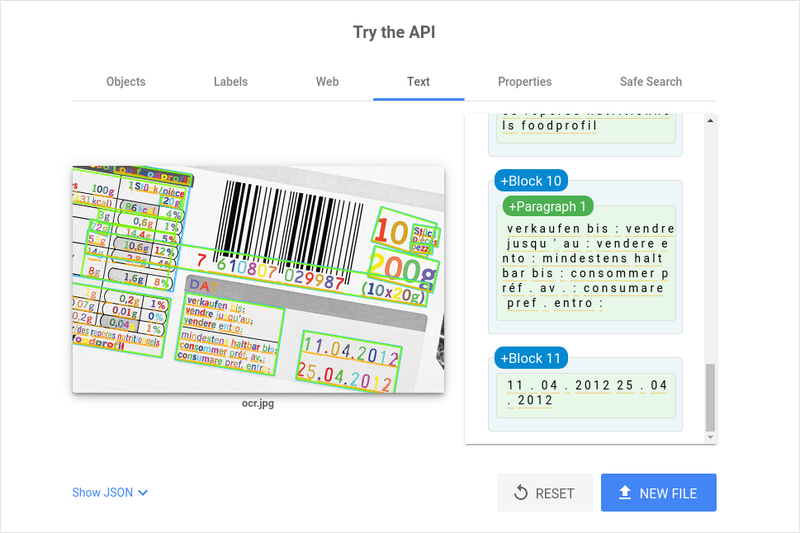
* 구글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 Block과 Paragraph로 구분해서 인식 결과를 나타내고 있었습니다. 구글 API가 이미지에 박스를 친 다음 박스별 텍스트의 내용을 알려준 것처럼, 문자 모델은 보통 두 단계로 이뤄집니다.

1. 먼저 입력받은 사진 속에서 문자의 위치를 찾아냅니다. 이 과정을 Text Detection(문자검출) 이라고 합니다. 딥러닝 기반 객체 검출 방법에는 Regression(회귀) 방식이나 Segmentation(세그멘테이션) 방식이 있습니다. Regression은 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습합니다. Segmentation은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)라고 볼 수 있습니다.


2. 찾은 문자 영역으로부터 문자를 읽어내는 것은 Text Recognition(문자인식) 입니다. 문자 인식은 사진 속에서 문자를 검출해 내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정입니다. 아래는 ICDAR15라는 OCR 데이터셋에서 단어 단위로 잘린 이미지입니다. 문자 인식 모델은 이렇게 작게 잘린 이미지가 들어오면 이미지 속에 어떤 단어가 포함됐는지 찾아내지요. 사실 이 과정은 이미지 문제보다는 자연어 처리에서 많은 영감을 받았습니다. 자연어 처리를 한다면 RNN이 떠오르실 텐데요. 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN 모델입니다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것이지요.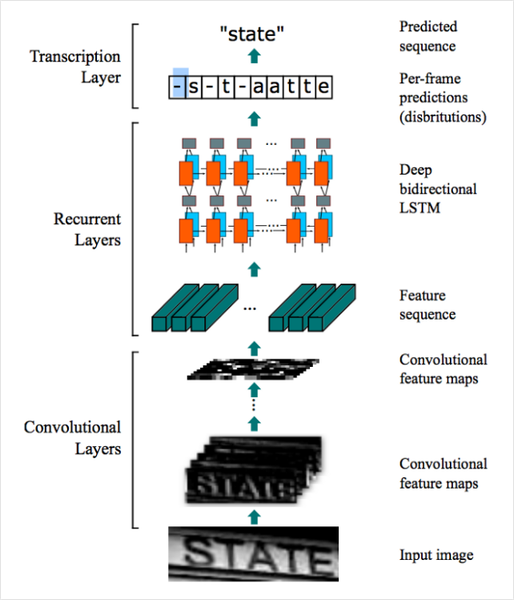이렇게 검출 결과로부터 인식 모델을 통해 문자를 인식하고 나면 구글 API의 결과처럼 사진 속 영역에 표시를 하고 그 영역에 어떤 문자가 적혀있는지 알 수 있는 OCR 시스템이 됩니다.


* 예를 들어 아래 카카오의 OCR 모델은 먼저 문자가 있는 영역의 정보 (coord, Text Recognition)를 찾아내고, 각 영역에서 문자를 인식하고 있습니다. 이렇게 문자 인식 모델은 Text Detection과 Recognition 두 과정을 통해서 사진 속의 문자를 읽을 수 있게 됩니다.
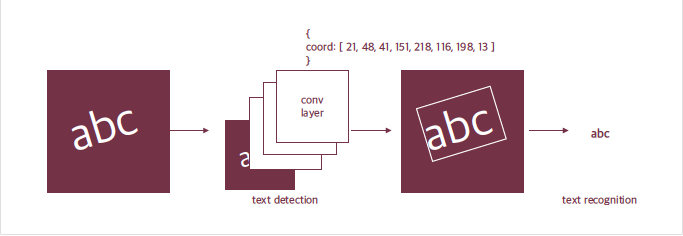
* 위 그림에서는 문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려 주는 방법을 제시하고 있습니다. 하지만 다른 도형이나 표현 방법을 사용할 수도 있을 것입니다.

# Step1. 검증용 데이터셋 준비
* 이미지는 저작권 없는 이미지사이트인  [https://unsplash.com/] 에서 가져왔습니다. 

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import cv2

import keras_ocr

from google.cloud import vision
import io

import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [14]:
images_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
file_list = os.listdir(images_dir)
file_list

['text09.jpg',
 'text14.jpg',
 'text04.jpg',
 'text08.jpg',
 'text10.jpg',
 'text05.jpg',
 'text13.jpg',
 'text02.jpg',
 'text15.jpg',
 'text07.jpg',
 'text01.jpg',
 'text12.jpg',
 'text06.jpg',
 'text11.jpg',
 'text03.jpg']

# Step2. keras-ocr, Google OCR API, Tesseract로 테스트 진행

## 1. keras-ocr

In [28]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [29]:
images = [keras_ocr.tools.read(os.path.join(images_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(images_dir, file)]) for file in file_list]

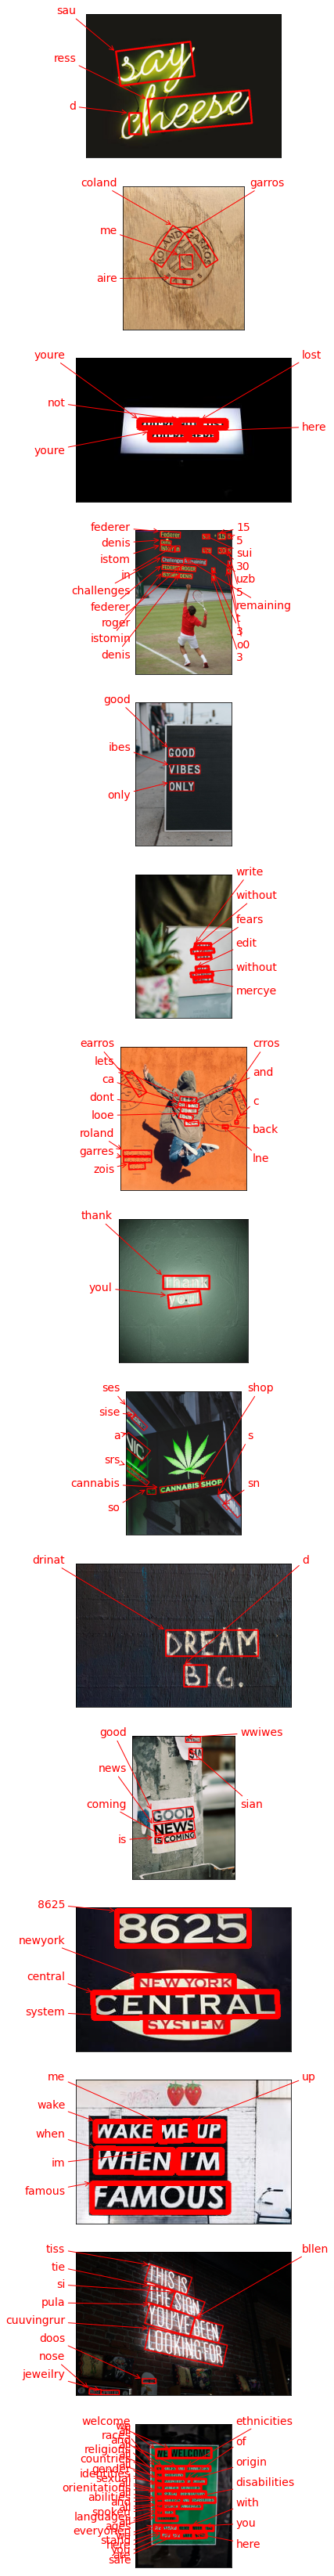

In [66]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 60))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. Google OCR API

In [33]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [34]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# # 입력 이미지 경로를 지정해 주세요.
# path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.jpg'

for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(images_dir, file))
    print()

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
# detect_text(path)

-rw-r--r-- 1 root root 2339 Feb 25 03:37 /aiffel/aiffel/ocr_python/my_google_api_key.json
[text09.jpg]
Texts:

"3
say
cheese
"

"3"

"say"

"cheese"
bounds: (104,275),(583,192),(616,385),(137,468)

[text14.jpg]
Texts:

"トRROR
"

"ト"

"RROR"
bounds: (480,299),(536,412),(459,450),(403,337)

[text04.jpg]
Texts:

"YOU'RE NOT LOST
YOU'RE HERE
"

"YOU'RE"

"NOT"

"LOST"

"YOU'RE"

"HERE"
bounds: (143,94),(174,94),(174,100),(143,100)

[text08.jpg]
Texts:

"Federer
SUI * 15 5
Denis
Istomin
UZB 30 5
Challenges Remaining
Ti
FEDERER ROGER
3
0OC
ISTOMIN DENIS
"

"Federer"

"SUI"

"*"

"15"

"5"

"Denis"

"Istomin"

"UZB"

"30"

"5"

"Challenges"

"Remaining"

"Ti"

"FEDERER"

"ROGER"

"3"

"0OC"

"ISTOMIN"

"DENIS"
bounds: (301,293),(382,298),(380,324),(299,319)

[text10.jpg]
Texts:

"GOOD
VIBES
ONLY
"

"GOOD"

"VIBES"

"ONLY"
bounds: (328,778),(561,778),(561,861),(328,861)

[text05.jpg]
Texts:

"WRITE
WITHOUT
FEAR.
EDIT
WITHOUT
MERCY.
"

"WRITE"

"WITHOUT"

"FEAR."

"EDIT"

"WITHOUT"

"MERCY."
bo

## 3. Tesseract

In [51]:
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
img_file_path = work_dir + '/text15.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png
/aiffel/aiffel/ocr_python/image/0005.png
/aiffel/aiffel/ocr_python/image/0006.png
/aiffel/aiffel/ocr_python/image/0007.png
/aiffel/aiffel/ocr_python/image/0008.png
/aiffel/aiffel/ocr_python/image/0009.png
/aiffel/aiffel/ocr_python/image/0010.png
/aiffel/aiffel/ocr_python/image/0011.png
/aiffel/aiffel/ocr_python/image/0012.png


In [52]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

WEN {| ~ £4


|


pK




SN




:


CANNABIS


©


o)


"


|


.


Done


# Step3. 테스트 결과 정리

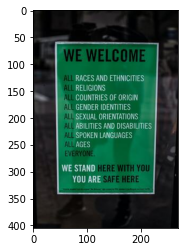

In [54]:
# 테스트 이미지1 확인
test_image_path = os.getenv('HOME')+'/aiffel/ocr_python/image/text03.jpg'
img_bgr = cv2.imread(test_image_path)    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
plt.imshow(img_rgb)
plt.show()

<AxesSubplot:>

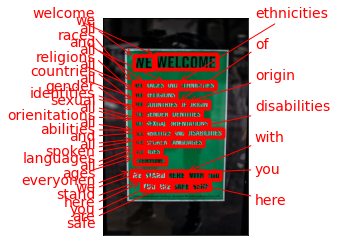

In [68]:
# keras ocr
keras_ocr.tools.drawAnnotations(image=images[14], predictions=prediction_groups[14][0])

In [55]:
# Google OCR API
detect_text(test_image_path)

Texts:

"WE WELCOME
ALL RACES AND ETHNICITIES
ALL RELIGIONS
ALL COUNTRIES OF ORIGIN
ALL GENDER IDENTITIES
ALL SEXUAL ORIENTATIONS
ALL ABILITIES AND DISABILITIES
ALL SPOKEN LANGUAGES
ALL AGES
EVERYONE
WE STAND HERE WITH YOU
YOU ARE SAFE HERE
"

"WE"

"WELCOME"

"ALL"

"RACES"

"AND"

"ETHNICITIES"

"ALL"

"RELIGIONS"

"ALL"

"COUNTRIES"

"OF"

"ORIGIN"

"ALL"

"GENDER"

"IDENTITIES"

"ALL"

"SEXUAL"

"ORIENTATIONS"

"ALL"

"ABILITIES"

"AND"

"DISABILITIES"

"ALL"

"SPOKEN"

"LANGUAGES"

"ALL"

"AGES"

"EVERYONE"

"WE"

"STAND"

"HERE"

"WITH"

"YOU"

"YOU"

"ARE"

"SAFE"

"HERE"
bounds: (164,305),(195,305),(195,322),(164,322)


In [56]:
# Tesseract
recognize_images(cropped_image_path_list)

WEN {| ~ £4


|


pK




SN




:


CANNABIS


©


o)


"


|


.


Done


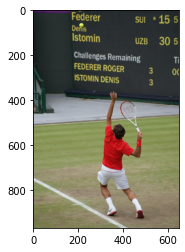

In [57]:
# 테스트 이미지2 확인
test_image_path = os.getenv('HOME')+'/aiffel/ocr_python/image/text08.jpg'
img_bgr = cv2.imread(test_image_path)    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
plt.imshow(img_rgb)
plt.show()

<AxesSubplot:>

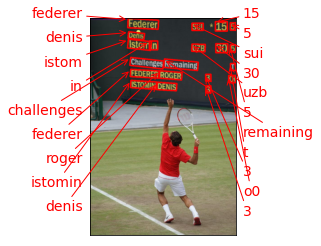

In [82]:
# keras ocr
keras_ocr.tools.drawAnnotations(image=images[3], predictions=prediction_groups[3][0])

In [58]:
# Google OCR API
detect_text(test_image_path)

Texts:

"Federer
SUI * 15 5
Denis
Istomin
UZB 30 5
Challenges Remaining
Ti
FEDERER ROGER
3
0OC
ISTOMIN DENIS
"

"Federer"

"SUI"

"*"

"15"

"5"

"Denis"

"Istomin"

"UZB"

"30"

"5"

"Challenges"

"Remaining"

"Ti"

"FEDERER"

"ROGER"

"3"

"0OC"

"ISTOMIN"

"DENIS"
bounds: (301,293),(382,298),(380,324),(299,319)


In [59]:
# Tesseract
recognize_images(cropped_image_path_list)

WEN {| ~ £4


|


pK




SN




:


CANNABIS


©


o)


"


|


.


Done


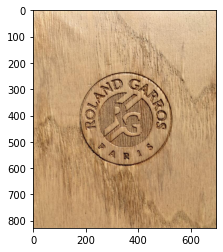

In [60]:
# 테스트 이미지3 확인
test_image_path = os.getenv('HOME')+'/aiffel/ocr_python/image/text14.jpg'
img_bgr = cv2.imread(test_image_path)    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
plt.imshow(img_rgb)
plt.show()

<AxesSubplot:>

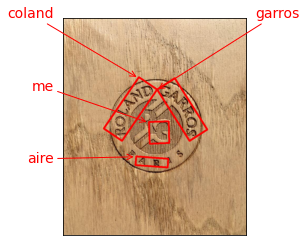

In [83]:
# keras ocr
keras_ocr.tools.drawAnnotations(image=images[1], predictions=prediction_groups[1][0])

In [61]:
# Google OCR API
detect_text(test_image_path)

Texts:

"トRROR
"

"ト"

"RROR"
bounds: (480,299),(536,412),(459,450),(403,337)


In [62]:
# Tesseract
recognize_images(cropped_image_path_list)

WEN {| ~ £4


|


pK




SN




:


CANNABIS


©


o)


"


|


.


Done


## Step4. 결과 분석과 결론 제시
1. 일반적인 텍스트의 경우 Google OCR의 인식률이 가장 높고 keras ocr의 인식률도 준수했지만, Tesseract의 인식률은 형편없는 수준이었다. 
2. 필기체 인식은 Google OCR이 월등한 인식률을 보여주었고, keras ocr과 Tesseract는 제대로 인식하지 못하였다.
3. 휘어지거나 회전된 텍스트의 경우 keras ocr이 완벽하진 않지만 그나마 인식률이 높았고, Google OCR과 Tesseract는 제대로 인식하지 못하였다.

그러므로 일반적인 텍스트나 필기체, 그리고 한글텍스트는 Google OCR API를 사용하는 것이 좋을 것 같고, 휘어지거나 회전된 텍스트인 경우는 keras ocr을 사용하는 것이 좋을 것 같다고 판단된다.

# 회고
* 신분증 인식, 스캔후 텍스트 변환등 이미 상용화되어 많이 쓰이고 있는 OCR의 원리를 파악하고 실습해 볼 수 있어 좋았다. 개인적으로 흥미가 많이 생기는 분야였고 앞으로 더 공부하면서 많이 활용해보고 싶다! 